# Improving the speed of feature extraction and similarity search

We will experiment with PCA and figure out what is the optimum length. of the features to use in our experiments.

## Reduce feature length with PCA

PCA (short for Principal Component Analysis) is a statistical procedure that questions if features representing the data are equally important. PCA is considered one of the go-to techniques for dimensionality reduction. Note that it does not eliminate redundant features, instead it generates a new set of features that are a linear combination of the input features. These linear features are orthogonal to each other, which is why all the redundant features are absent. These features are known as principal components.

In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160
%matplotlib inline

In [2]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

In [3]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [4]:
def classname(str):
    return str.split('/')[-2]


def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [5]:
print("Accuracy on original feature set : ", calculate_accuracy(feature_list[:]))

Accuracy on original feature set :  (88.46, 98.77001905441284)


In [6]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = %.3f" %pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  17.64 % ,	Time = 17.509
For PCA Dimensions =  2 ,	Accuracy =  26.49 % ,	Time = 18.178
For PCA Dimensions =  3 ,	Accuracy =  33.76 % ,	Time = 17.596
For PCA Dimensions =  4 ,	Accuracy =  40.53 % ,	Time = 17.678
For PCA Dimensions =  5 ,	Accuracy =  46.28 % ,	Time = 17.776
For PCA Dimensions =  10 ,	Accuracy =  66.43 % ,	Time = 17.939
For PCA Dimensions =  20 ,	Accuracy =  79.79 % ,	Time = 18.444
For PCA Dimensions =  50 ,	Accuracy =  86.84 % ,	Time = 23.036
For PCA Dimensions =  75 ,	Accuracy =  88.0 % ,	Time = 24.457
For PCA Dimensions =  100 ,	Accuracy =  88.56 % ,	Time = 25.807
For PCA Dimensions =  150 ,	Accuracy =  88.79 % ,	Time = 19.610
For PCA Dimensions =  200 ,	Accuracy =  88.77 % ,	Time = 22.228


Let's plot the test time accuracy for each PCA dimensions

/var/folders/x6/f9t0_d2d1v12tgmn5dhptygc0000gn/T/ipykernel_17798/707730212.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


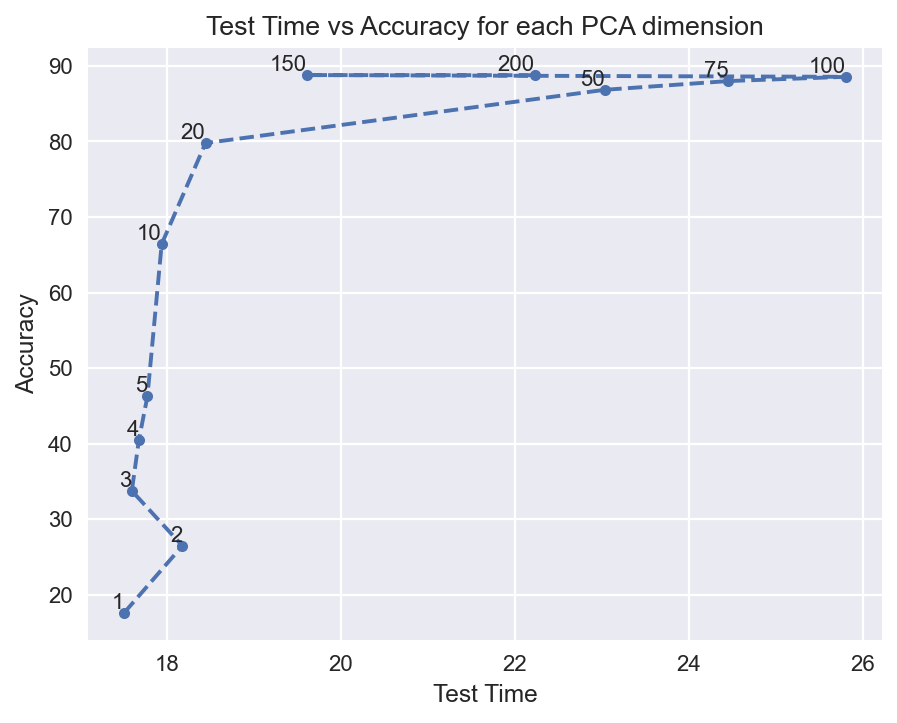

In [7]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("pca-test_time_vs_acc.pdf", bbox_inches='tight')
f.savefig("pca-test_time_vs_acc.png", bbox_inches='tight')

In [8]:
f.savefig('pca-test_time_vs_acc.pdf', bbox_inches='tight')
f.savefig('pca-test_time_vs_acc.png', transparent=False, bbox_inches='tight')

Let's plot the variance of each PCA dimension.

/var/folders/x6/f9t0_d2d1v12tgmn5dhptygc0000gn/T/ipykernel_17798/1022954802.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


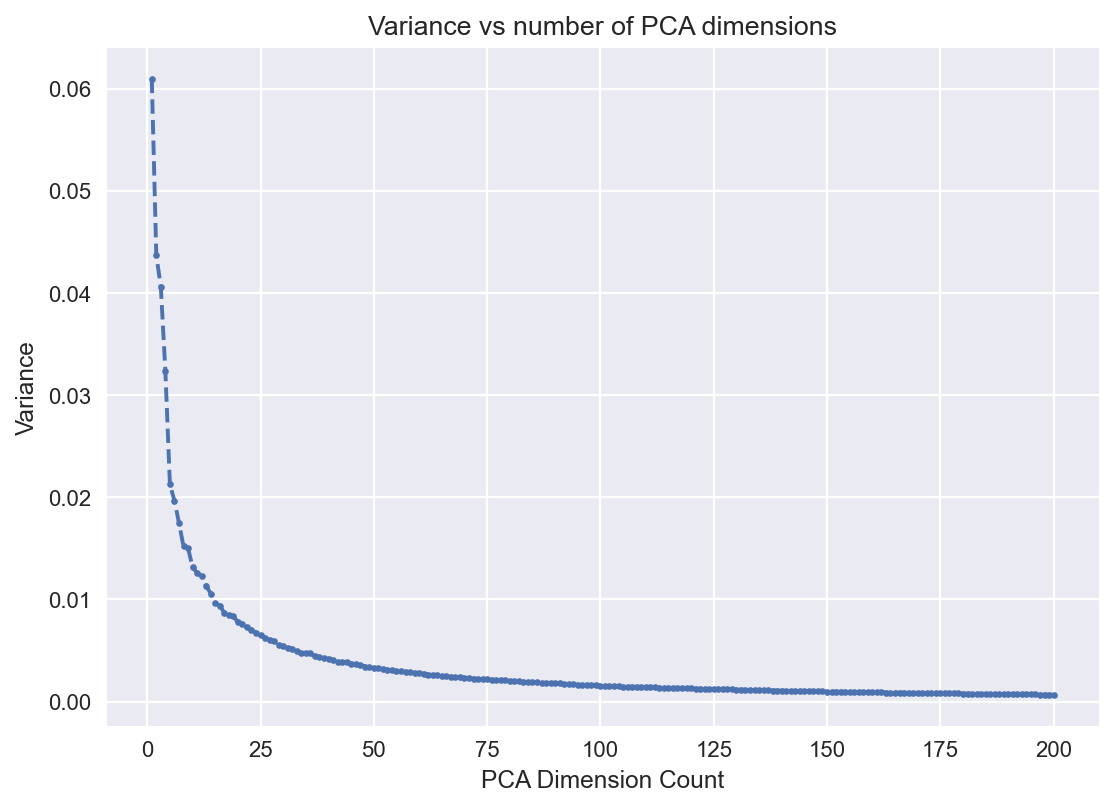

In [9]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201), pca.explained_variance_ratio_, 'o--', markersize=3)
plt.title('Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

f.savefig("Variance vs number of PCA dimensions.pdf", bbox_inches='tight')
f.savefig("Variance vs number of PCA dimensions.png", bbox_inches='tight')

## Cumalative Variance vs Number of PCA dimensions.

/var/folders/x6/f9t0_d2d1v12tgmn5dhptygc0000gn/T/ipykernel_17798/1337899521.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


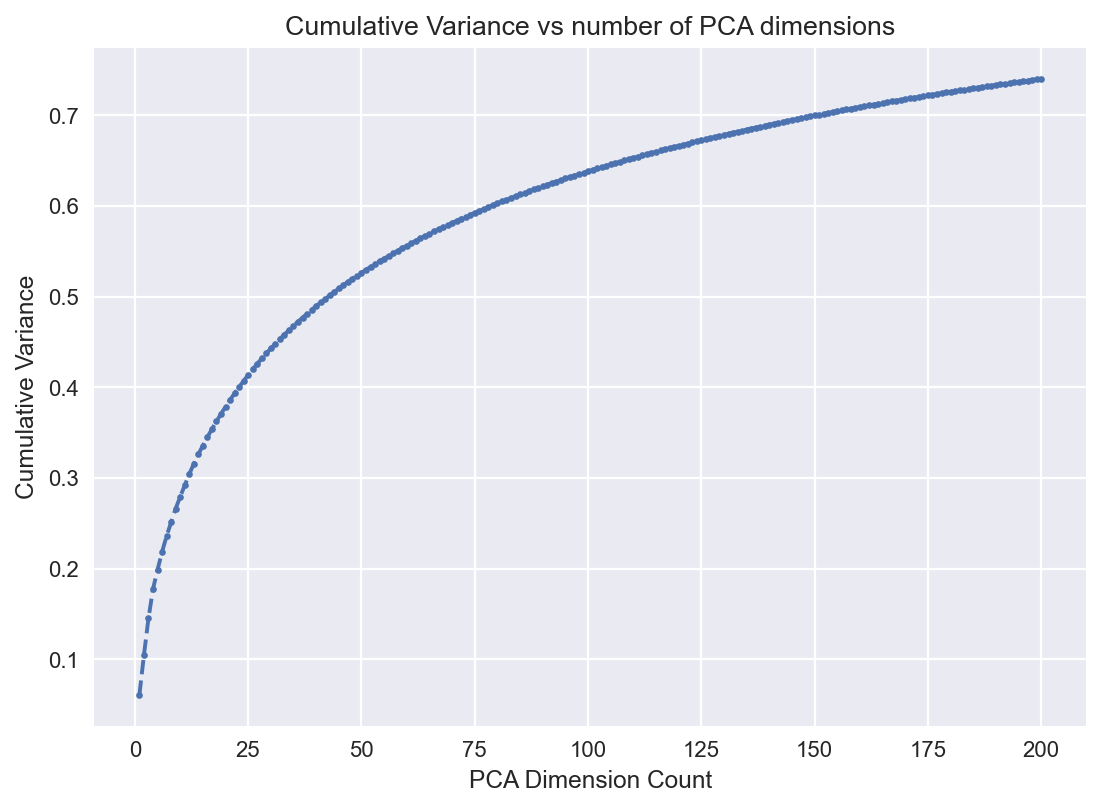

In [10]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201),
         pca.explained_variance_ratio_.cumsum(),
         'o--',
         markersize=3)
plt.title('Cumulative Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

f.savefig("Cumulative Variance vs number of PCA dimensions.pdf",
          bbox_inches='tight')
f.savefig("Cumulative Variance vs number of PCA dimensions.png",
          bbox_inches='tight')

## Plotting the effect of PCA dimension vs Classification Accuracy

/var/folders/x6/f9t0_d2d1v12tgmn5dhptygc0000gn/T/ipykernel_17798/4133629899.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


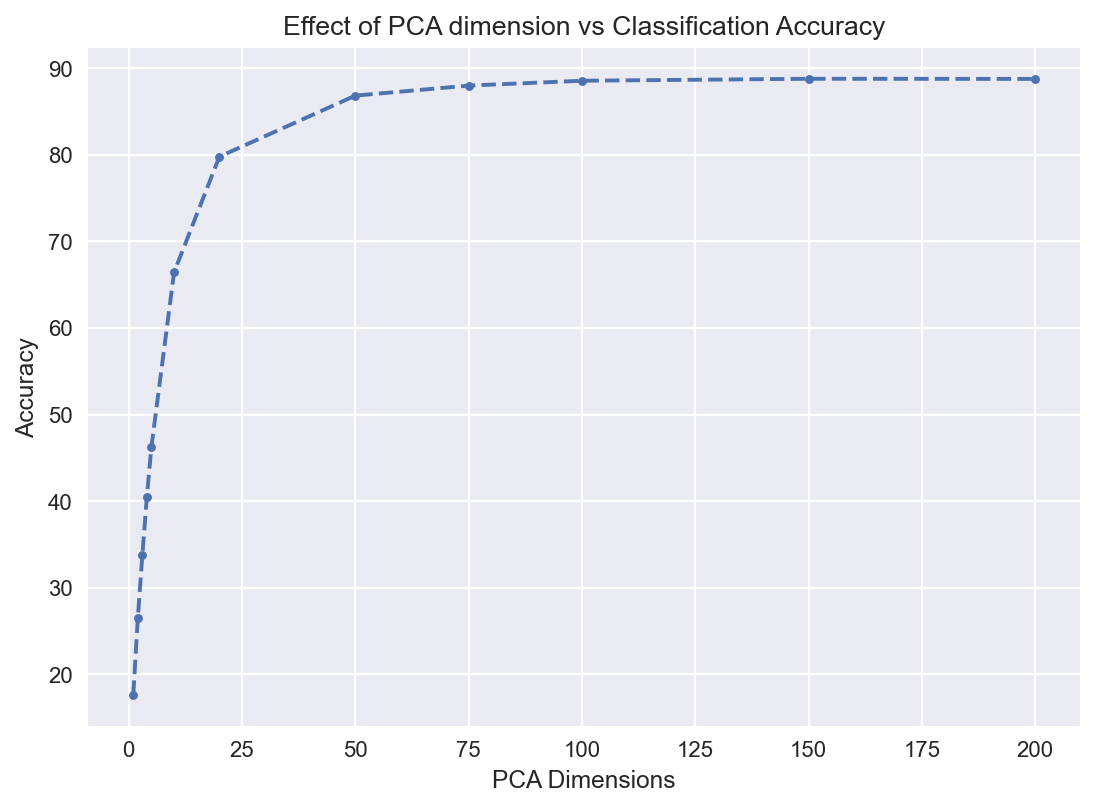

In [11]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_accuracy, 'o--', markersize=4)
plt.title('Effect of PCA dimension vs Classification Accuracy')
plt.xlabel('PCA Dimensions')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimension vs Classification Accuracy.pdf",
          bbox_inches='tight')
f.savefig("Effect of PCA dimension vs Classification Accuracy.png",
          bbox_inches='tight')

We will now plot the effect of number of PCA dimensions vs time.

/var/folders/x6/f9t0_d2d1v12tgmn5dhptygc0000gn/T/ipykernel_17798/216974427.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


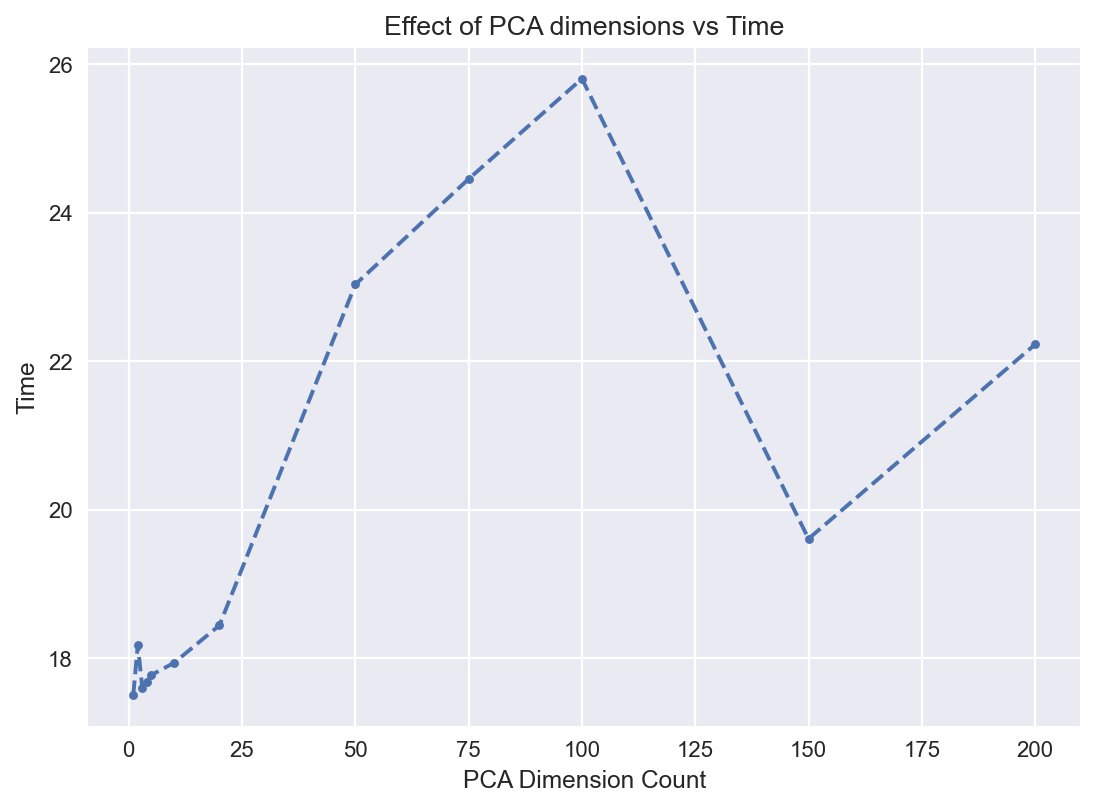

In [12]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_time, 'o--', markersize=4)
plt.title('Effect of PCA dimensions vs Time')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Time')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimensions vs Time.pdf", bbox_inches='tight')
f.savefig("Effect of PCA dimensions vs Time.png", bbox_inches='tight')

Now let's compare different options available for similarity search

In [13]:
num_items = 100000
num_dimensions = 100

In [14]:
dataset = np.random.randn(num_items, num_dimensions)
dataset /= np.linalg.norm(dataset, axis=1).reshape(-1, 1)

In [15]:
randomIndex = random.randint(0, num_items)
query = dataset[randomIndex]

## Brute force

In [16]:
%timeit NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(dataset)

1.9 ms ± 6.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(dataset)
%timeit neighbors.kneighbors([query])

3.05 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## k-d Tree

In [18]:
%timeit NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dataset)

182 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

18.6 ms ± 80.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Ball Tree

In [20]:
%timeit NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(dataset)

234 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

17.4 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Annoy

Annoy (Approximate Nearest Neighbors Oh Yeah) is a C++ library with Python bindings for searching nearest neighbors. Synonymous with speed, it was released by Spotify and is used in production to serve their music recommendations.

In [22]:
from annoy import AnnoyIndex

In [23]:
random_image_index = random.randint(0, num_items)

In [24]:
annoy_index = AnnoyIndex(
    num_dimensions)  # Length of item vector that will be indexed
for i in range(num_items):
    annoy_index.add_item(i, dataset[i])
annoy_index.build(40)

/var/folders/x6/f9t0_d2d1v12tgmn5dhptygc0000gn/T/ipykernel_17798/1673951326.py:1: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  annoy_index = AnnoyIndex(


True

In [25]:
%timeit annoy_index.get_nns_by_vector(query, 5, include_distances=True )

46.1 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Let's time the indexing for different number of tree:

In [26]:
annoy_training_time = []
annoy_test_time = []
annoy_trees = [
    1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300
]
for num_trees in annoy_trees:
    t = AnnoyIndex(2048)  # Length of item vector that will be indexed
    for i in range(num_images):
        feature = feature_list[i]
        t.add_item(i, feature)
    start_time = time.time()
    t.build(num_trees)  #50 trees
    end_time = time.time()
    annoy_training_time.append(end_time - start_time)
    start_time = time.time()
    indices = t.get_nns_by_vector(feature_list[random_image_index],
                                  5,
                                  include_distances=True)
    end_time = time.time()
    annoy_test_time.append(end_time - start_time)
    print("For number of trees = ", num_trees, ",\tTime to train = ",
          annoy_training_time[-1], ",\tTime to test = ", annoy_test_time[-1])

/var/folders/x6/f9t0_d2d1v12tgmn5dhptygc0000gn/T/ipykernel_17798/3703383969.py:7: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(2048)  # Length of item vector that will be indexed


For number of trees =  1 ,	Time to train =  0.06500792503356934 ,	Time to test =  0.004697084426879883
For number of trees =  2 ,	Time to train =  0.06921100616455078 ,	Time to test =  0.004688739776611328
For number of trees =  3 ,	Time to train =  0.0768880844116211 ,	Time to test =  0.004908084869384766
For number of trees =  4 ,	Time to train =  0.08130717277526855 ,	Time to test =  0.0049190521240234375
For number of trees =  5 ,	Time to train =  0.07758522033691406 ,	Time to test =  0.0029706954956054688
For number of trees =  10 ,	Time to train =  0.0998079776763916 ,	Time to test =  0.004553079605102539
For number of trees =  20 ,	Time to train =  0.16889095306396484 ,	Time to test =  0.004244089126586914
For number of trees =  30 ,	Time to train =  0.2604198455810547 ,	Time to test =  0.00521397590637207
For number of trees =  40 ,	Time to train =  0.3714282512664795 ,	Time to test =  0.00445103645324707
For number of trees =  50 ,	Time to train =  0.42643308639526367 ,	Time t

## Effort of number of trees vs Training time

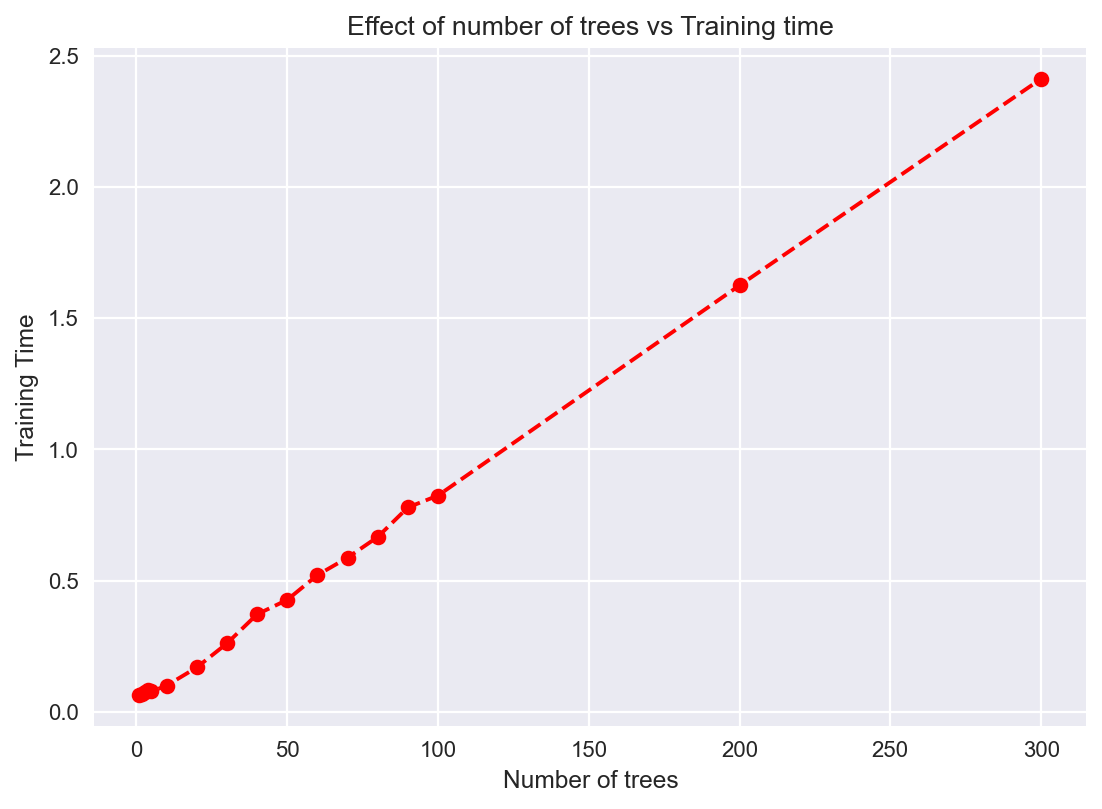

In [27]:
plt.plot(annoy_trees, annoy_training_time, 'or--')
plt.title('Effect of number of trees vs Training time')
plt.xlabel('Number of trees')
plt.ylabel('Training Time')
plt.grid(True)
plt.show()

## Effect of number of trees vs Test time

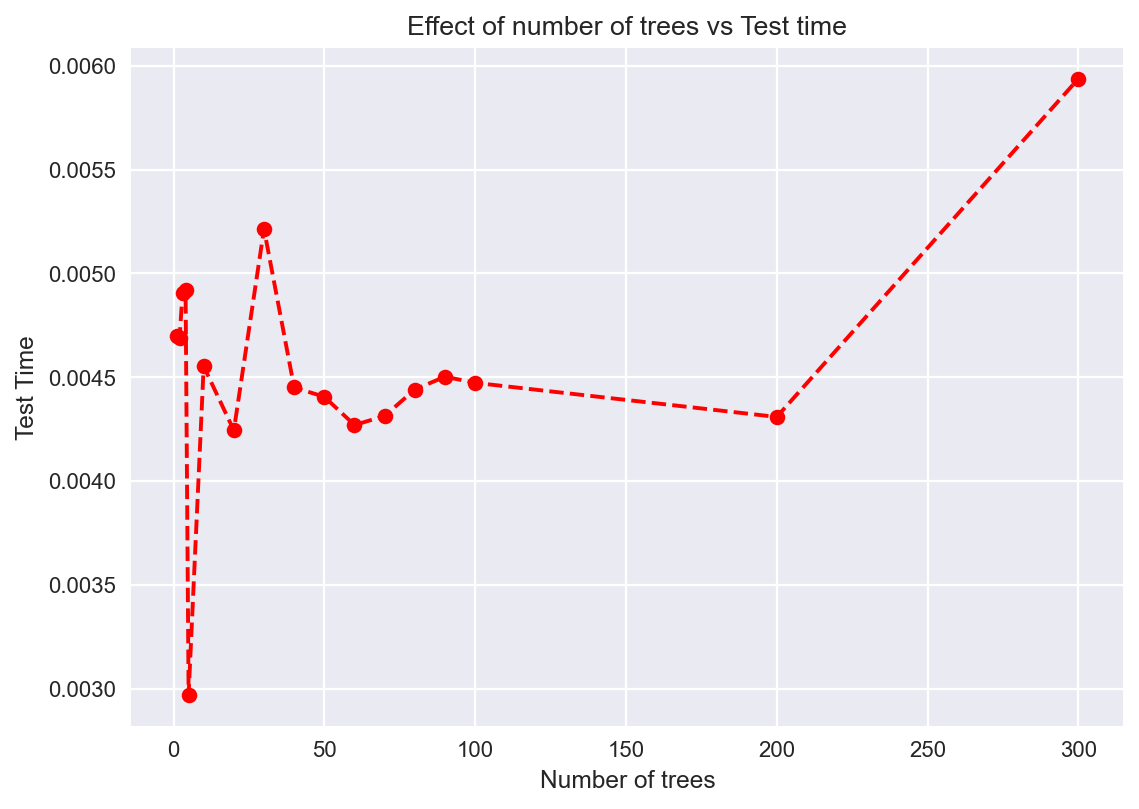

In [28]:
plt.plot(annoy_trees, annoy_test_time, 'or--')
plt.title('Effect of number of trees vs Test time')
plt.xlabel('Number of trees')
plt.ylabel('Test Time')
plt.grid(True)
plt.show()

## Falconn

In [30]:
import falconn

In [32]:
parameters = falconn.LSHConstructionParameters()
num_tables = 1
parameters.l = num_tables
parameters.dimension = num_dimensions
parameters.distance_function = falconn.DistanceFunction.EuclideanSquared
parameters.lsh_family = falconn.LSHFamily.CrossPolytope
parameters.num_rotations = 1
parameters.num_setup_threads = 1
parameters.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
falconn.compute_number_of_hash_functions(16, parameters)

index = falconn.LSHIndex(parameters)
%time index.setup(dataset)

query_object = index.construct_query_object()
num_probes = 1
query_object.set_num_probes(num_probes)

%timeit query_object.find_k_nearest_neighbors(query, 5)

CPU times: user 115 ms, sys: 5.49 ms, total: 121 ms
Wall time: 120 ms
1.91 µs ± 4.73 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [33]:
query = dataset[5000]
print(query_object.find_k_nearest_neighbors(query, 5))

[5000, 90899, 20185, 54658, 6311]
